# Натянуть сову на линейное пространство

Создайте эмбеддинги слов и визуализируйте векторные операции над ними: сложение, вычитание, взятие ближайшего, дальнейшего и прочее. Сравните качество представлений gensim и BERT с точки зрения операций над словами, докажите примерами.

Для создания эмбеддингов с gensim обучите модель на нормализованных текстовых данных. Данные найдите на kaggle или выберите один из предложенных датасетов. Для создания эмбеддингов с BERT используйте предобученные модели.

Предлагаемые датасеты:
 - [sentiment твитов про ковид](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification)
 - [Amazon product reviews](https://www.kaggle.com/kashnitsky/hierarchical-text-classification)
 - [Отзывы интернет-магазина](https://www.kaggle.com/shymammoth/shopee-reviews)
 - [Тексты статей конференции NIPS](https://www.kaggle.com/rowhitswami/nips-papers-1987-2019-updated?select=papers.csv)

In [1]:
import pandas as pd
import umap
import matplotlib.pyplot as plt

plt.style.use('dark_background')

%matplotlib inline

# df0 = pd.read_csv('archive/train_40k.csv')
df0 = pd.read_csv('archive/unlabeled_150k.csv')
df0.head(5)

,Title,Text
0,Proraso Proraso Liquid Cream After-Shave 3.4oz,I do not know what they were thinking with all...
1,"PondCare 169J Algae Fix, 2-1/2 Gallon",I have used Algae Fix once a week in my pond a...
2,Philips Norelco Bodygroom Shaver,Norelco got it right with their new Bodygroom....
3,CHAMPION Neoprene Knee Support with Open Patella,"very comfortable support, at least compared to..."
4,Melissa & Doug Baby Zoo Animals Stamp Set,The stamps are a little smaller than I thought...


## Нормализация

In [2]:
from nltk.corpus import stopwords
import nltk

In [3]:
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /Users/maria/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
nltk.download('stopwords')
eng_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/maria/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
%%time
def charMap(c):
    if c >= 'a' and c <= 'z':
        return c
    return ' '
def gcutWord(w):
    # return w
    # return stemmer.stem(lemmatizer.lemmatize(w))
    return wordnet.morphy(w) or w
isNotStopword = lambda word: word not in eng_stopwords
def processComment(s):
    s = ''.join(map(charMap, s.lower()))
    if False:
        filt = lambda x: filter(isNotStopword,x)
    else:
        filt = lambda x: x
    return ' '.join(map(gcutWord, filt(s.split())))

dfg = df0.Text.apply(processComment)
dfg

CPU times: user 1min 28s, sys: 1.22 s, total: 1min 29s
Wall time: 1min 35s


0         i do not know what they be thinking with all o...
1         i have use algae fix once a week in my pond an...
2         norelco get it right with their new bodygroom ...
3         very comfortable support at least compare to t...
4         the stamp are a little smaller than i thought ...
                                ...                        
149995    i wa so excite to see this on amazon i go ahea...
149996    my daughter kick it a few times she laugh and ...
149997    i have be using the oral b electric toothbrush...
149998    look colorful after application however i do n...
149999    have these candy as a kid i describe these as ...
Name: Text, Length: 150000, dtype: object

In [7]:
!pip install gensim

     |████████████████████████████████| 24.0 MB 569 kB/s eta 0:00:011
     |████████████████████████████████| 58 kB 7.2 MB/s  eta 0:00:01


## Gensim

In [8]:
import gensim
from gensim.models import Word2Vec

In [9]:
%%time
comms = [i.split() for i in dfg]
words = {}
for sentence in comms:
    for word in sentence:
        words[word] = (words.get(word) or 0) + 1
words_freq = [i[0] for i in sorted(words.items(), key=lambda x: x[1])][::-1]

CPU times: user 3.9 s, sys: 289 ms, total: 4.18 s
Wall time: 4.27 s


In [10]:
%%time
gmodel = Word2Vec( sentences=comms
                 , sg=False  # cbow model
                 , vector_size=100
                 , window=5
                 , seed=0
                 , epochs=15
                 , min_count=1
                 , workers=8
                 )
print('размерность векторов слов в модели:', gmodel.wv.vectors.shape)

размерность векторов слов в модели: (71569, 100)
CPU times: user 5min 19s, sys: 3.71 s, total: 5min 23s
Wall time: 1min 52s


In [11]:
import random

class Umapper:
    def __init__(self):
        self.words = []
        for i in range(1000):
            ind = random.randint(0, len(words_freq))
            self.words.append(words_freq[ind])
        for i in ['item', 'product', 'toy', 'microscope', 'vendor', 'seller', 'sellers']:
            self.words.append(i)
    def doJob(self, sim):
        vecs = [np.array(sim.vector_from(i)) for i in self.words]
        points = umap.UMAP(random_state=30).fit_transform(vecs)
        plt.figure(figsize=(12, 11))
        plt.scatter(x=points[:, 0], y=points[:, 1], s=10)
        plt.show()
        fig, ax = plt.subplots(figsize=(14, 11))
        ax.scatter(points[:500, 0], points[:500, 1])

        for i, txt in enumerate(gmodel.wv.index_to_key[:500]):
            ax.annotate(txt, (points[i, 0], points[i, 1]))
        plt.show()
umapper = Umapper()

In [12]:
def compose(*funcs):
    def res(*args, **kwargs):
        r = funcs[-1](*args, **kwargs)
        for f in funcs[-2::-1]:
            r = f(r)
        return r
    return res

In [13]:
import operator
import numpy as np

class Similar:
    def cut(self, x):
        return x
    def vector_from(self, word):
        return self.vector_from_impl(self.cut(word))
    def most_similar_by_word(self, word):
        return self.most_similar_by_vector(self.vector_from(word))
    def least_similar_by_word(self, word):
        return self.least_similar_by_vector(self.vector_from(word))
    def least_similar_by_vector(self, vect):
        return self.most_similar_by_vector(-vect)
    def printHelper(self, it):
        for i in it:
            print('\t', i[0], sep='')
    def printSim(self, vec):
        self.printHelper(self.most_similar_by_vector(vec))
    def printOpp(self, vec):
        self.printHelper(self.least_similar_by_vector(vec))
    def visualize_op(self, op, l, r, cmp=[]):
        l0, r0 = l, r
        l, r = self.cut(l), self.cut(r)
        txt = l0 + ' `' + op.__name__ + '` ' + r0
        print(txt)
        lv = self.vector_from(l)
        rv = self.vector_from(r)
        ov = op(lv, rv) / 2
        self.printSim(ov)
        plt.figure(figsize=(14, 14))
        le = len(cmp) + 3
        plt.yticks(range(0, le), [l0, r0, '?'] + cmp)
        plt.imshow(np.stack([lv, rv, ov] + list(map(self.vector_from, cmp))))
        plt.title(txt)
        plt.gca().set_aspect(len(lv) / le)
        plt.show()
    
class SimilarGENSIM(Similar):
    def __init__(self, model):
        self.model = model
    def cut(self, w):
        return gcutWord(w)
    def vector_from_impl(self, word):
        return self.model.wv[word]
    def most_similar_by_vector(self, vec):
        return self.model.wv.similar_by_vector(vec)

def visualizeEveryth(s):
    s.visualize_op(operator.sub, 'son', 'man', ['daughter'])
    s.visualize_op(operator.add, 'flower', 'girl', ['pony', 'princess'])
    def printSim(w):
        print('similar to ' + w)
        s.printSim(s.vector_from(w))
    printSim('girl')
    printSim('russia')
    printSim('item')
    printSim('buy')
    printSim('three')
    def printUnSim(w):
        print('?opposite? to ' + w)
        s.printOpp(s.vector_from(w))
    printUnSim('flower')
    printUnSim('man')
    printUnSim('buy')
smgensim = SimilarGENSIM(gmodel)

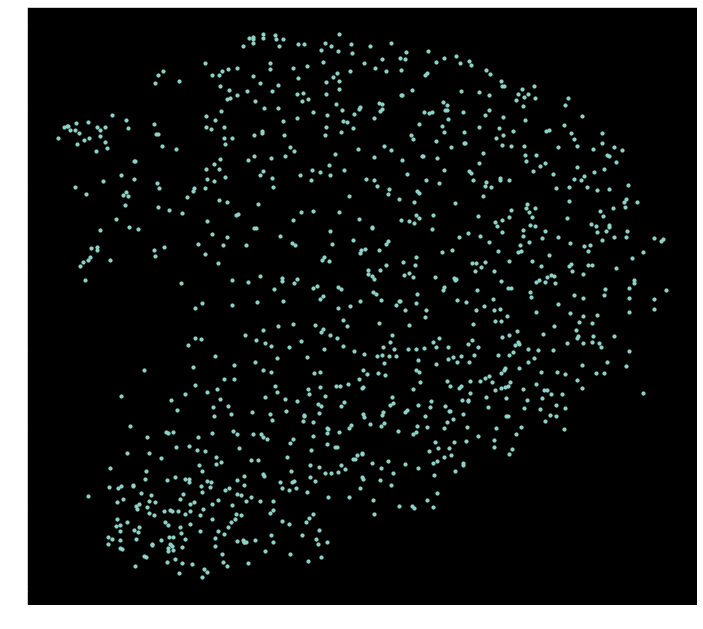

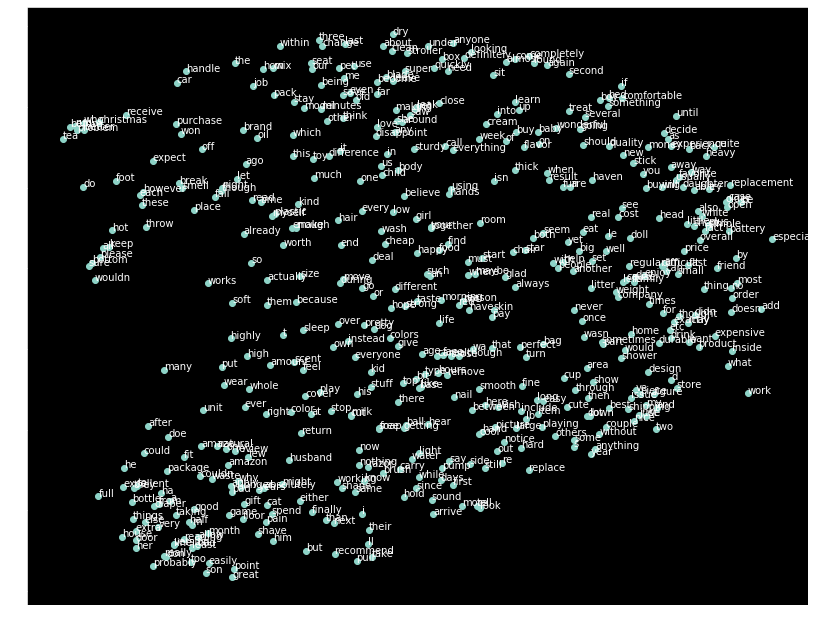

CPU times: user 9.08 s, sys: 767 ms, total: 9.85 s
Wall time: 9.89 s


In [14]:
%%time
umapper.doJob(smgensim)

son `sub` man
	son
	daughter
	grandson
	granddaughter
	daugher
	nephew
	twins
	daugther
	grandaughter
	husband


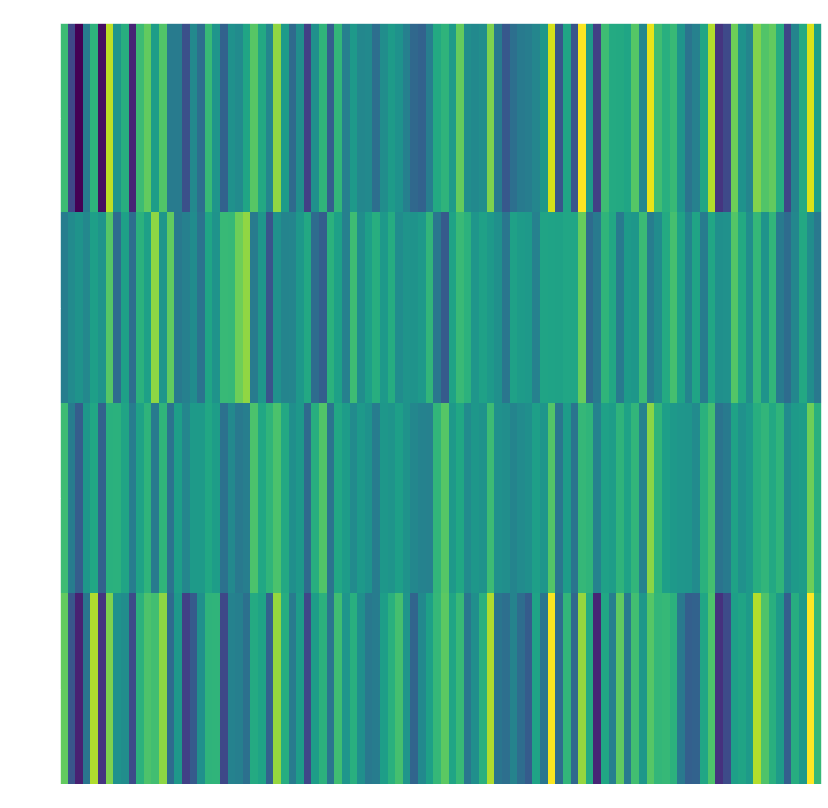

flower `add` girl
	girl
	flower
	pony
	princess
	fairy
	jewel
	mermaid
	boy
	unicorn
	belle


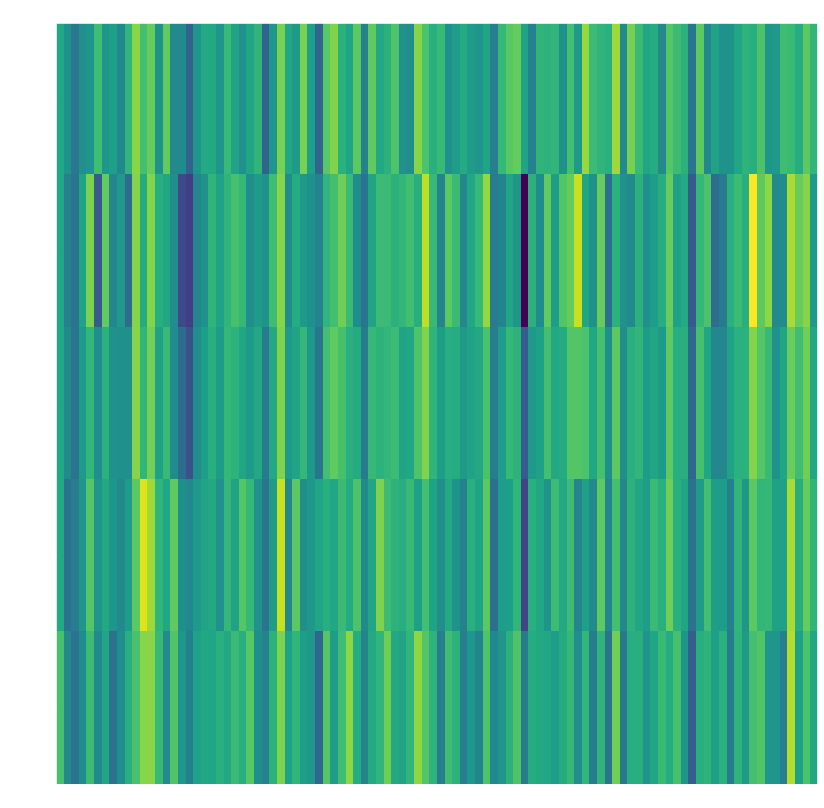

similar to girl
	girl
	boy
	guy
	kid
	pony
	daughter
	granddaughter
	cousin
	sis
	grandchild
similar to russia
	russia
	australia
	jij
	supplierthanksmax
	japan
	norway
	rosanna
	mexico
	maryland
	colonial
similar to item
	item
	product
	toy
	microscope
	seller
	easel
	dollhouse
	vendor
	hairdryer
	otoscope
similar to buy
	buy
	purchase
	order
	buying
	purchasing
	ordering
	choose
	receive
	borrow
	reorder
similar to three
	three
	four
	two
	six
	five
	seven
	ten
	eight
	several
	nine
?opposite? to flower
	maintenace
	exires
	justify
	beyone
	beleaguer
	testis
	management
	greaat
	osteoarthritic
	forit
?opposite? to man
	thelabel
	sanitary
	masonnice
	deflate
	gettingenough
	castleberry
	lowest
	lactosid
	oscial
	thumbtac
?opposite? to buy
	and
	also
	rebalancing
	slowly
	muscular
	painfully
	gynecomastia
	aslit
	crowsfeet
	glower
CPU times: user 659 ms, sys: 94.3 ms, total: 753 ms
Wall time: 541 ms


In [15]:
%%time
visualizeEveryth(smgensim)

In [17]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 782 kB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 12.9 MB/s eta 0:00:01     |██████████████████████▎         | 1.6 MB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 895 kB 21.0 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 397 kB/s  eta 0:00:01


## Bert
https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

In [18]:
import torch
from transformers import BertTokenizer, BertModel

In [19]:
%%time
class SimilarBERT(Similar):
    def __init__(self):
        self.model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        self.model.eval()
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        check = words_freq[:2000]
        self.known = list(zip(check, map(self.vector_from, check)))
    def cut(self, w):
        return '[CLS] ' + w + ' [SEP]'
    def vector_from_impl(self, word):
        toks  = self.tokenizer.tokenize(word)
        itoks = self.tokenizer.convert_tokens_to_ids(toks)
        ttensor = torch.tensor([itoks])
        with torch.no_grad():
            outputs = self.model(ttensor)
            hidden = outputs[2]
            tvecs = hidden[-2][0]
            return torch.mean(tvecs, dim=0)
        # return self.model.wv[word]
    def most_similar_by_vector(self, vec):
        sim = [(i, torch.cosine_similarity(vec, i[1], 0).item()) for i in self.known]
        srt = sorted(sim, key=lambda x: x[1])[::-1]
        return [(i[0][0], i[1]) for i in srt[:10]]
smbert = SimilarBERT()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

CPU times: user 1min 45s, sys: 5.44 s, total: 1min 51s
Wall time: 2min 55s


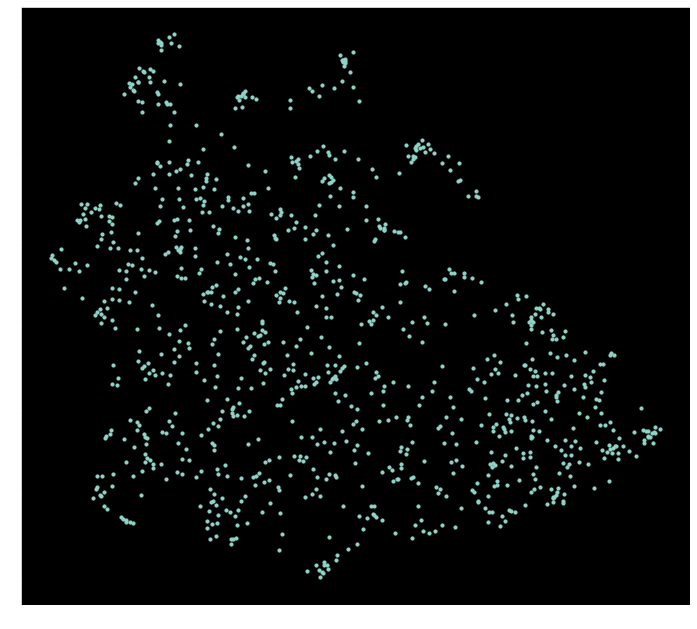

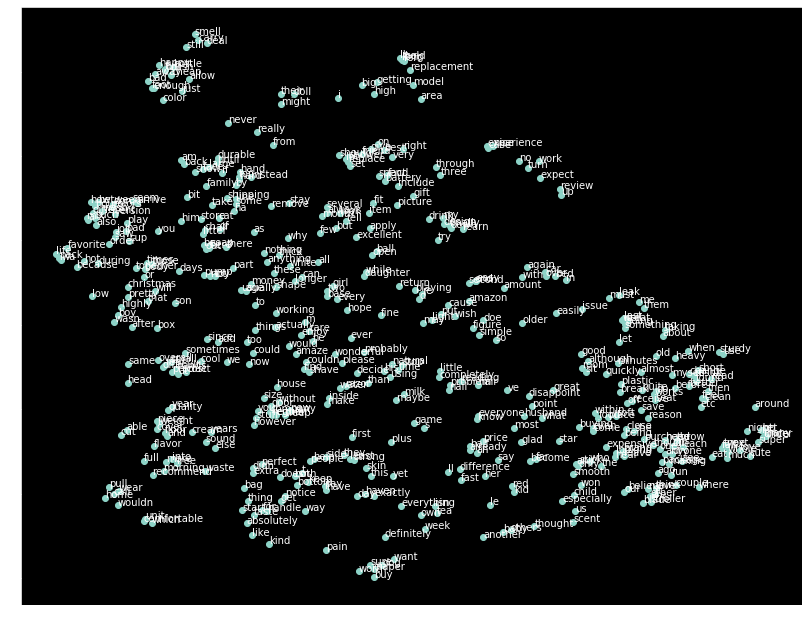

CPU times: user 50.8 s, sys: 1.29 s, total: 52.1 s
Wall time: 52 s


In [20]:
%%time
umapper.doJob(smbert)

son `sub` man
	grandchild
	son
	child
	infant
	daughter
	grandson
	toddler
	pregnancy
	toothbrush
	crib


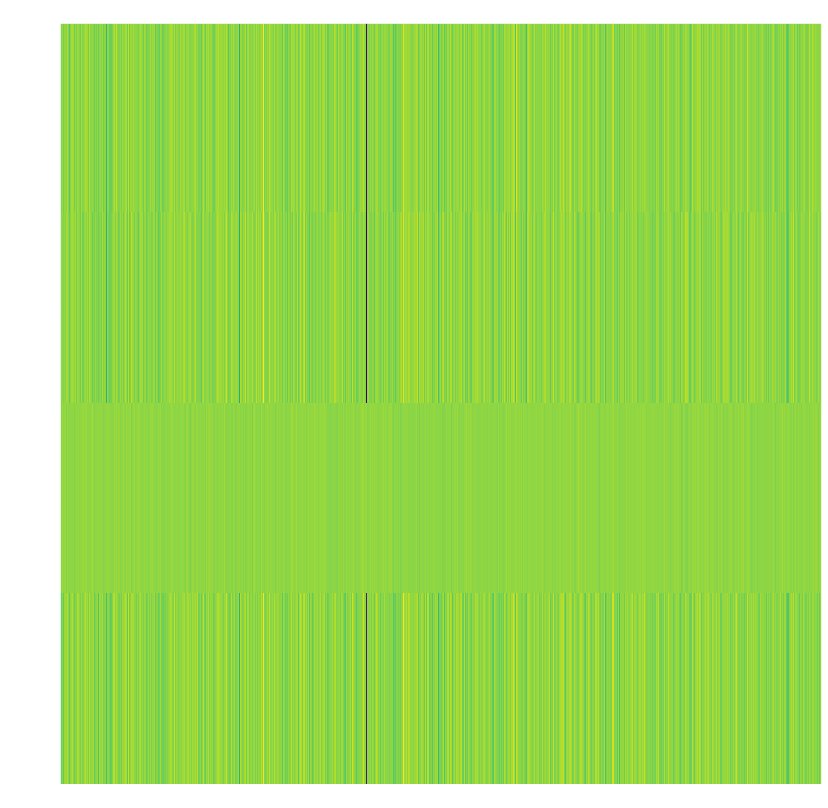

flower `add` girl
	lemon
	flower
	genie
	baby
	bird
	banana
	pill
	gift
	chocolate
	tree


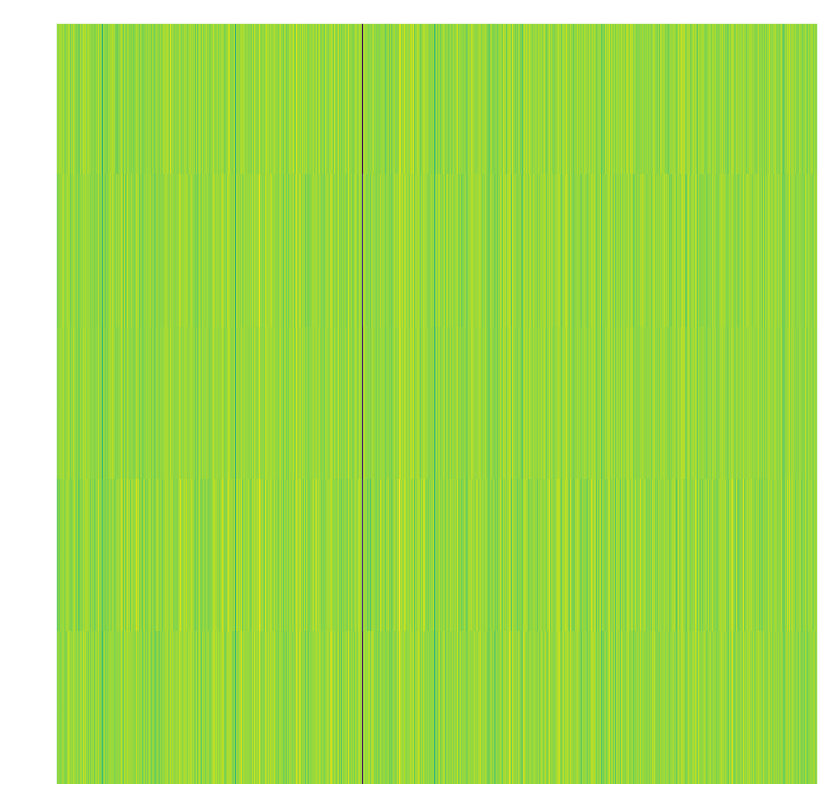

similar to girl
	girl
	guy
	woman
	boy
	kid
	girlfriend
	man
	boyfriend
	strawberry
	banana
similar to russia
	china
	soy
	salt
	medicine
	seal
	winter
	system
	bath
	safety
	ship
similar to item
	item
	complaint
	fabric
	pattern
	type
	basis
	box
	important
	device
	product
similar to buy
	buy
	create
	move
	teach
	allow
	get
	heal
	explain
	learn
	remove
similar to three
	three
	four
	five
	two
	one
	six
	ten
	another
	zero
	lots
?opposite? to flower
	draw
	didnt
	moisturizer
	source
	difference
	gluten
	match
	nd
	doesnt
	disappoint
?opposite? to man
	moisturizer
	dishwasher
	gluten
	toothpaste
	disposable
	symptom
	toothbrush
	moisturize
	difference
	shampoo
?opposite? to buy
	moisturizer
	dishwasher
	source
	symptom
	toothpaste
	overall
	acne
	gluten
	difference
	velcro
CPU times: user 1.56 s, sys: 62 ms, total: 1.62 s
Wall time: 1.68 s


In [21]:
%%time
visualizeEveryth(smbert)

In [22]:
smbert.printSim(smbert.vector_from('great'))

	great
	awesome
	incredible
	wonderful
	wow
	fantastic
	excellent
	delicious
	huge
	fabulous


# Projector

Из прошлого задания вы выяснили наиболее хорошую для представления связей между словами модель. Спроецируйте ~2-3 тысячи наиболее популярных слов из выбранного корпуса в tensorflow projector.

In [23]:
import numpy as np
import copy

def restrict_w2v(w2v, restricted_word_set):
    new_vectors = []
    new_index_to_key = []
    new_key_to_index = {}

    for i in range(len(w2v.index_to_key)):
        word = w2v.index_to_key[i]
        vec = w2v.vectors[i]
        if word in restricted_word_set:
            new_key_to_index[word] = len(new_index_to_key)
            new_index_to_key.append(word)
            new_vectors.append(vec)

    w2v.vectors = np.array(new_vectors)
    w2v.index_to_key = np.array(new_index_to_key)
    w2v.key_to_index = new_key_to_index
    w2v.index2word = np.array(new_index_to_key)
    return w2v

restrict_w2v(copy.deepcopy(smgensim.model.wv), words_freq[:3000]).save_word2vec_format('./archive/cut_model')

!python -m gensim.scripts.word2vec2tensor -i ./archive/cut_model -o ./archive/out_tensor

2021-12-18 22:06:19,859 - word2vec2tensor - INFO - running /Users/maria/opt/anaconda3/lib/python3.8/site-packages/gensim/scripts/word2vec2tensor.py -i ./archive/cut_model -o ./archive/out_tensor
2021-12-18 22:06:19,859 - keyedvectors - INFO - loading projection weights from ./archive/cut_model
2021-12-18 22:06:20,057 - utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (3000, 100) matrix of type float32 from ./archive/cut_model', 'binary': False, 'encoding': 'utf8', 'datetime': '2021-12-18T22:06:20.025890', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'load_word2vec_format'}
2021-12-18 22:06:20,253 - word2vec2tensor - INFO - 2D tensor file saved to ./archive/out_tensor_tensor.tsv
2021-12-18 22:06:20,253 - word2vec2tensor - INFO - Tensor metadata file saved to ./archive/out_tensor_metadata.tsv
2021-12-18 22:06:20,254 - word2vec2tensor - INFO - finished running word2vec2tensor.py


http://projector.tensorflow.org